**ZID**:z5518601 
**Name**:Tianxiong Wu

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Preparation](#1.1-Data-Preparation)
3. [Task A – Classification: Hot Event Detection](#Task-A:Classification(Hot-event-detection))
    - [A.1 Define Hot Label]
    - [A.2 Feature Engineering]
    - [A.3 Train / Val / Test Split]
    - [A.4 Neural Network Classifier]
    - [A.5 Evaluation & Confusion Matrix]
4. [Task B – Regression: Temperature Prediction](#Task-B:-Regression-(Temperature-prediction))
    - [B.1 Random Split – Model & Evaluation](#2.1-Model-development-(Random-Split-Regression))
    - [B.2 Year-wise Split – Model & Evaluation](#2.3-Model-development-(year-wise-split-&-target-normalisation))
5. [Final Evaluation Cell (Hidden Test Set)](#Final-Evaluation-Cell-(Hidden-Test-Set))
6. [Model & Scaler Export Summary](#Model-&-Scaler-Export-Summary)

## Introduction

This notebook addresses two supervised learning tasks using neural networks:
- A binary classification task to detect **hot events** in the Amazon.
- A regression task to predict **monthly temperature values**.

The model inputs include oceanic climate mode indices (ENSO, NAO, TSA, TNA) and cyclically encoded `month`.

## Task A: Classification (Hot event detection)

## 1.1 Data Preparation

### A.1 Define Hot Label
- Binary variable Hot is defined as:
  - 1 if temperature > threshold of that month
  - 0 otherwise

In [1]:
!pip install tensorflow

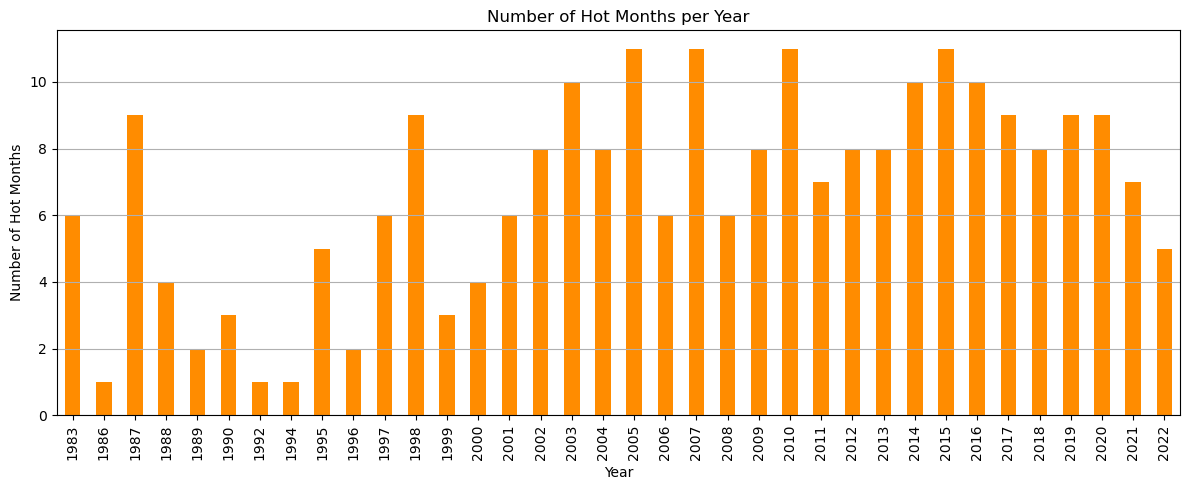

In [2]:
# Step 1: Load data, generate Hot labels, and visualise hot months per year
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1.1: Load temperature and climate mode data
df = pd.read_csv('Amazon_temperature_student.csv')

# Step 1.2: Load threshold values per month (no year needed)
threshold_df = pd.read_csv('thresholds.csv')  # contains columns: Month, Threshold

# Step 1.3: Generate Year and Month columns based on index
start_year = 1982
n_months = df.shape[0]
df['Year'] = start_year + (np.arange(n_months) // 12)
df['Month'] = (np.arange(n_months) % 12) + 1

# Step 1.4: Map monthly threshold to each row
month_to_thresh = dict(zip(threshold_df['month'], threshold_df['threshold']))
df['threshold'] = df['month'].map(month_to_thresh)

# Step 1.5: Generate binary Hot label
df['Hot'] = (df['temperature'] > df['threshold']).astype(int)

# Step 1.6: Visualise number of hot months per year
hot_counts = df[df['Hot'] == 1].groupby('Year').size()

plt.figure(figsize=(12, 5))
hot_counts.plot(kind='bar', color='darkorange')
plt.title('Number of Hot Months per Year')
plt.xlabel('Year')
plt.ylabel('Number of Hot Months')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 1.2 Model development

### A.2 Feature Engineering

- Features used: ENSO, NAO, TSA, TNA, Month (cyclically encoded using sin/cos)
- `Year` is **not used** as a feature (per assignment constraint).

In [3]:
# Step 2: Feature preparation and model training for classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib

# Step 2.1: Cyclic encode month
df['Month_sin'] = np.sin(2 * np.pi * (df['Month'] - 1) / 12)
df['Month_cos'] = np.cos(2 * np.pi * (df['Month'] - 1) / 12)

# Step 2.2: Select features and target
features = ['ENSO', 'TSA', 'TNA', 'NAO', 'Month_sin', 'Month_cos']
X = df[features].values
y = df['Hot'].values

### A.3 Train / Val / Test Split

- Random split into 60% train, 20% validation, 20% test.
- Features standardised using `StandardScaler` (fit on train only).

In [4]:
# Step 2.3: Split into train/val/test (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Step 2.4: Standardise features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'classifier_feature_scaler.pkl')

['classifier_feature_scaler.pkl']

### A.4 Neural Network Classifier

- Architecture: `Input → Dense(16) → Dense(8) → Dense(1, sigmoid)`
- Loss: `binary_crossentropy`, Optimiser: `Adam`
- EarlyStopping enabled.
- Accuracy vs Epoch curve plotted.

D:\SoftwareEngineering\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.5328 - loss: 0.7258 - val_accuracy: 0.5102 - val_loss: 0.7034
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5017 - loss: 0.7236 - val_accuracy: 0.5204 - val_loss: 0.6847
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5207 - loss: 0.6885 - val_accuracy: 0.5306 - val_loss: 0.6704
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5095 - loss: 0.6952 - val_accuracy: 0.5510 - val_loss: 0.6564
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5236 - loss: 0.6737 - val_accuracy: 0.5816 - val_loss: 0.6437
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6051 - loss: 0.6616 - val_accuracy: 0.6020 - val_loss: 0.6323
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5687 - loss: 0.6490 - val_accuracy: 0.6224 - val_loss: 0.6220
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6535 - loss: 0.6096 - val_accuracy: 0.

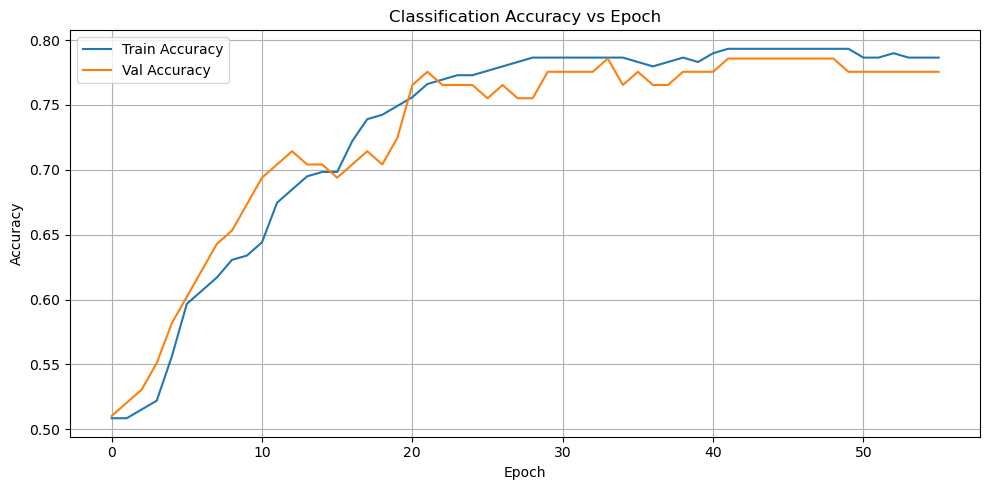

In [5]:
# Step 2.5: Define neural network architecture
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # 二分类任务
])

# 编译模型
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 2.6: Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# Step 2.7: Plot accuracy vs epoch
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model.save('hot_event_classifier.h5')

## 1.3 Model evaluation

### A.5 Evaluation & Confusion Matrix

- Model evaluated on test set:
  - Confusion matrix plotted (positive class = `1`)
  - Balanced Accuracy, Sensitivity (TPR), and Specificity (TNR) calculated

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


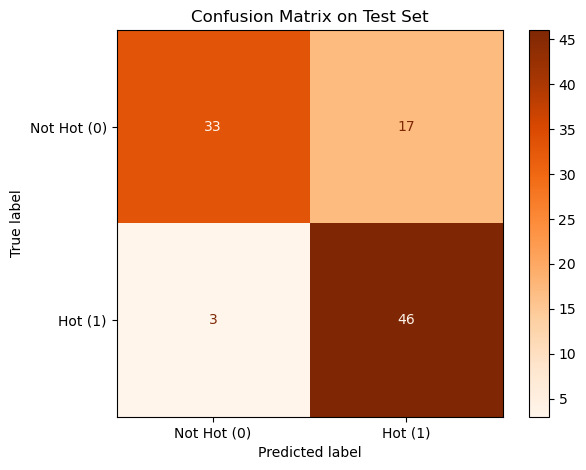

Balanced Accuracy: 0.7994
True Positive Rate (Sensitivity): 0.9388
True Negative Rate (Specificity): 0.6600


In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, recall_score

# Step 3.1: Predict on the test set
y_pred_proba = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)  # 二分类概率转为标签

# Step 3.2: Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Hot (0)', 'Hot (1)'])
disp.plot(cmap='Oranges')
plt.title('Confusion Matrix on Test Set')
plt.grid(False)
plt.tight_layout()
plt.show()

# Step 3.3: Evaluation metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)  # TPR
specificity = recall_score(y_test, y_pred, pos_label=0)  # TNR

print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"True Positive Rate (Sensitivity): {sensitivity:.4f}")
print(f"True Negative Rate (Specificity): {specificity:.4f}")


## Task B: Regression (Temperature prediction)

## B.1 Random Split – Model & Evaluation

- Input features same as classifier.
- Output: temperature (continuous)
- Target values **not scaled** (per requirement).
- Train/val/test = 60/20/20 random split.
- Network structure: `Dense(32) → Dense(16) → Dense(1)`
- Loss: MSE, Metrics: MAE
- MSE Loss vs Epoch curve plotted
- Evaluated on test set using:
  - Pearson Correlation Coefficient (r)
  - Mean Absolute Error (MAE)

### 2.1 Model development (Random Split Regression)

In [7]:
# Step B1: Prepare data for regression task
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

# Step B1.1: Define features and target (Temperature)
X = df[features].values  # features: ENSO, TSA, TNA, NAO, Month_sin, Month_cos
y = df['temperature'].values

# Step B1.2: Split randomly into train / val / test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step B1.3: Standardise features (do not touch y!)
reg_scaler = StandardScaler()
X_train_scaled = reg_scaler.fit_transform(X_train)
X_val_scaled = reg_scaler.transform(X_val)
X_test_scaled = reg_scaler.transform(X_test)


Epoch 1/100


D:\SoftwareEngineering\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 741.4414 - mae: 27.2217 - val_loss: 726.2161 - val_mae: 26.9403
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 724.2698 - mae: 26.9030 - val_loss: 710.5234 - val_mae: 26.6457
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 706.9904 - mae: 26.5770 - val_loss: 695.6809 - val_mae: 26.3631
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 692.0942 - mae: 26.2928 - val_loss: 680.9622 - val_mae: 26.0790
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 675.9979 - mae: 25.9777 - val_loss: 665.3929 - val_mae: 25.7747
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 663.0818 - mae: 25.7260 - val_loss: 648.6003 - val_mae: 25.4420
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 642.1058 - mae: 25.3089 - val_loss: 629.9672 - val_mae: 25.0672
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 617.7730 - mae: 24.8141 - val_loss: 609.0002 - val_mae: 24.6372
Epoch 9/100
10/10 ━━

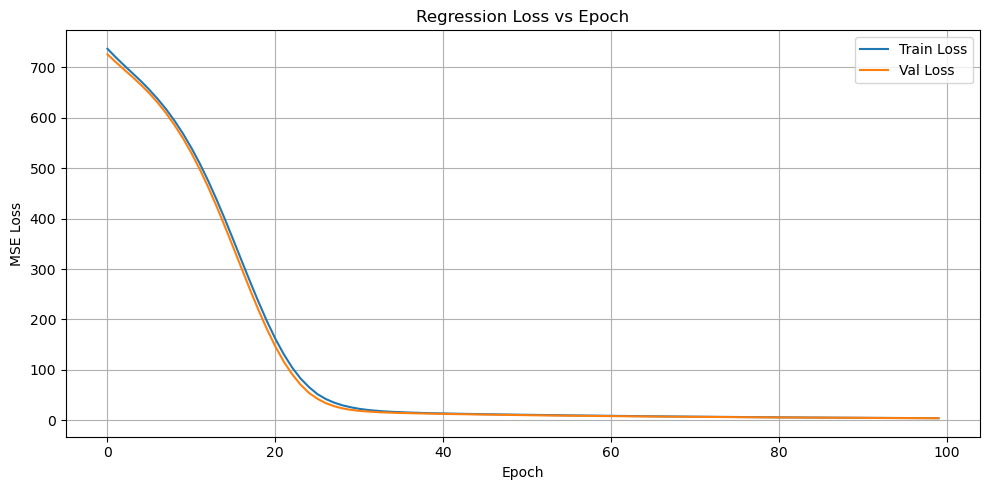

In [8]:
# Step B2: Build and train a regression neural network
from tensorflow.keras.losses import MeanSquaredError

# 构建模型结构（参数数量 < 数据数 / 10）
reg_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1)  # 回归输出
])

# 编译模型
reg_model.compile(optimizer='adam',
                  loss=MeanSquaredError(),
                  metrics=['mae'])  # 使用 MAE 作为评估指标

# 训练模型
reg_history = reg_model.fit(X_train_scaled, y_train,
                            validation_data=(X_val_scaled, y_val),
                            epochs=100,
                            batch_size=32,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                            verbose=1)

# 绘制 loss vs epoch 图
plt.figure(figsize=(10, 5))
plt.plot(reg_history.history['loss'], label='Train Loss')
plt.plot(reg_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Regression Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 2.2 Model evaluation (Random Split Regression)

In [9]:
# Step B3: Evaluate regression model on test set
y_pred = reg_model.predict(X_test_scaled).ravel()

r, _ = pearsonr(y_test, y_pred)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"Pearson Correlation (r): {r:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Pearson Correlation (r): 0.2109
Mean Absolute Error (MAE): 1.6750


## B.2 Year-wise Split – Model & Evaluation
- Years were randomly shuffled and grouped into:
  - 60% training years, 20% validation years, 20% test years
- Input features scaled using `StandardScaler`
- Target values (`temperature`) scaled using `MinMaxScaler` (fit on training target only)
- Same model structure reused
- Model trained on scaled targets
- Evaluation:
  - Predictions inverse-transformed
  - Pearson r and MAE reported
  - True vs Predicted scatter plot plotted

### 2.3 Model development (year-wise split & target normalisation) 

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Step B4.1: Split year-wise — group by year and assign to sets
# Step (p): 年度划分 train/val/test（使用年份分组）
years = df['Year'].unique()
np.random.seed(42)
np.random.shuffle(years)

n_total = len(years)
n_train = int(n_total * 0.6)
n_val = int(n_total * 0.2)
train_years = years[:n_train]
val_years = years[n_train:n_train + n_val]
test_years = years[n_train + n_val:]

# 依据年份划分数据
df_train = df[df['Year'].isin(train_years)]
df_val = df[df['Year'].isin(val_years)]
df_test = df[df['Year'].isin(test_years)]

# 选特征和目标
features = ['ENSO', 'TSA', 'TNA', 'NAO', 'Month_sin', 'Month_cos']
X_train_y = df_train[features].values
X_val_y = df_val[features].values
X_test_y = df_test[features].values

y_train_y = df_train['temperature'].values.reshape(-1, 1)
y_val_y = df_val['temperature'].values.reshape(-1, 1)
y_test_y = df_test['temperature'].values.reshape(-1, 1)

# Step (q): 特征标准化（和随机划分一致）
year_feature_scaler = StandardScaler()
X_train_y_scaled = year_feature_scaler.fit_transform(X_train_y)
X_val_y_scaled = year_feature_scaler.transform(X_val_y)
X_test_y_scaled = year_feature_scaler.transform(X_test_y)

# 目标值使用 MinMaxScaler 单独归一化
target_scaler = MinMaxScaler()
y_train_y_scaled = target_scaler.fit_transform(y_train_y)
y_val_y_scaled = target_scaler.transform(y_val_y)
y_test_y_scaled = target_scaler.transform(y_test_y)


Epoch 1/100


D:\SoftwareEngineering\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.1820 - mae: 0.3376 - val_loss: 0.1058 - val_mae: 0.2528
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0823 - mae: 0.2194 - val_loss: 0.0805 - val_mae: 0.2215
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0614 - mae: 0.1922 - val_loss: 0.0655 - val_mae: 0.2006
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0537 - mae: 0.1825 - val_loss: 0.0569 - val_mae: 0.1873
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0482 - mae: 0.1720 - val_loss: 0.0533 - val_mae: 0.1811
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0345 - mae: 0.1463 - val_loss: 0.0524 - val_mae: 0.1808
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0348 - mae: 0.1472 - val_loss: 0.0510 - val_mae: 0.1774
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0335 - mae: 0.1432 - val_loss: 0.0496 - val_mae: 0.1745
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0338 - mae: 0.1426 - val

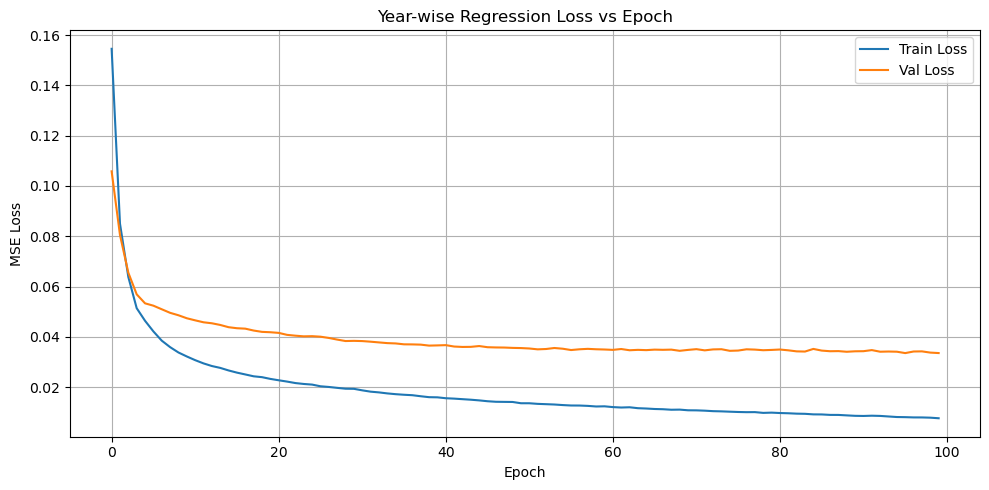

In [11]:
# Step (r): 模型结构不变，重新训练
year_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_y_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1)
])

year_model.compile(optimizer='adam',
                   loss='mse',
                   metrics=['mae'])

# Step (r): 训练
year_history = year_model.fit(X_train_y_scaled, y_train_y_scaled,
                              validation_data=(X_val_y_scaled, y_val_y_scaled),
                              epochs=100,
                              batch_size=32,
                              callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                              verbose=1)

# Step (s): 绘制 loss 曲线
plt.figure(figsize=(10, 5))
plt.plot(year_history.history['loss'], label='Train Loss')
plt.plot(year_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Year-wise Regression Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 2.4 Model evaluation (Year-wise Split)

In [12]:
# Step (t): Year-wise 
y_pred_scaled = year_model.predict(X_test_y_scaled)
y_pred = target_scaler.inverse_transform(y_pred_scaled).ravel()
y_true = y_test_y.ravel()

# Pearson 
r_year, _ = pearsonr(y_true, y_pred)

# MAE
mae_year = mean_absolute_error(y_true, y_pred)

print(f"[Year-wise] Pearson Correlation (r): {r_year:.4f}")
print(f"[Year-wise] Mean Absolute Error (MAE): {mae_year:.4f}")


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EF910A8FE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[Year-wise] Pearson Correlation (r): 0.7003
[Year-wise] Mean Absolute Error (MAE): 0.4216


## Final Evaluation Cell (Hidden Test Set)

In [13]:
# Step 1: Save all models and scalers
import joblib

# Save classifier
model.save('hot_event_classifier.h5')
joblib.dump(scaler, 'classifier_feature_scaler.pkl')

# Save regressor (random split)
reg_model.save('regressor_random_split.h5')
joblib.dump(reg_scaler, 'regressor_feature_scaler.pkl')

# Save regressor (year-wise split)
year_model.save('regressor_yearwise_split.h5')
joblib.dump(year_feature_scaler, 'regressor_yearwise_feature_scaler.pkl')
joblib.dump(target_scaler, 'regressor_yearwise_target_scaler.pkl')


['regressor_yearwise_target_scaler.pkl']

In [ ]:
# Step 2: Final evaluation cell for hidden test data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, recall_score, mean_absolute_error
from scipy.stats import pearsonr

# Load hidden test set (assumed preloaded as hidden_df)
hidden_df = pd.read_csv('hidden_test.csv')  # provided by course staff

# Step 2.1: Cyclic encoding of Month
hidden_df['Month_sin'] = np.sin(2 * np.pi * (hidden_df['Month'] - 1) / 12)
hidden_df['Month_cos'] = np.cos(2 * np.pi * (hidden_df['Month'] - 1) / 12)
features = ['ENSO', 'TSA', 'TNA', 'NAO', 'Month_sin', 'Month_cos']

# === Classifier Evaluation ===
X_cls = joblib.load('classifier_feature_scaler.pkl').transform(hidden_df[features])
cls_model = load_model('hot_event_classifier.h5')
y_true_cls = hidden_df['Hot'].values
y_pred_cls = (cls_model.predict(X_cls).ravel() > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_true_cls, y_pred_cls)
ConfusionMatrixDisplay(cm, display_labels=['Not Hot', 'Hot']).plot(cmap='Oranges')
plt.title("Confusion Matrix - Classifier on Hidden Test")
plt.tight_layout()
plt.show()

# Metrics
print("[Classifier]")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true_cls, y_pred_cls):.4f}")
print(f"Sensitivity (TPR): {recall_score(y_true_cls, y_pred_cls):.4f}")
print(f"Specificity (TNR): {recall_score(y_true_cls, y_pred_cls, pos_label=0):.4f}")

# === Random-split Regressor Evaluation ===
X_reg = joblib.load('regressor_feature_scaler.pkl').transform(hidden_df[features])
y_true_reg = hidden_df['Temperature'].values
reg_model = load_model('regressor_random_split.h5')
y_pred_reg = reg_model.predict(X_reg).ravel()

plt.figure()
plt.scatter(y_true_reg, y_pred_reg, alpha=0.5)
plt.title("Random Split: True vs Predicted Temperature")
plt.xlabel("True Temp")
plt.ylabel("Predicted Temp")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n[Regressor - Random Split]")
r1, _ = pearsonr(y_true_reg, y_pred_reg)
mae1 = mean_absolute_error(y_true_reg, y_pred_reg)
print(f"Pearson r: {r1:.4f}")
print(f"MAE: {mae1:.4f}")

# === Year-wise Regressor Evaluation ===
X_yw = joblib.load('regressor_yearwise_feature_scaler.pkl').transform(hidden_df[features])
y_yw_true = hidden_df['Temperature'].values.reshape(-1, 1)
y_model = load_model('regressor_yearwise_split.h5')
y_scaled_pred = y_model.predict(X_yw)
y_pred_yw = joblib.load('regressor_yearwise_target_scaler.pkl').inverse_transform(y_scaled_pred).ravel()

plt.figure()
plt.scatter(y_yw_true.ravel(), y_pred_yw, alpha=0.5)
plt.title("Year-wise Split: True vs Predicted Temperature")
plt.xlabel("True Temp")
plt.ylabel("Predicted Temp")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n[Regressor - Year-wise Split]")
r2, _ = pearsonr(y_yw_true.ravel(), y_pred_yw)
mae2 = mean_absolute_error(y_yw_true.ravel(), y_pred_yw)
print(f"Pearson r: {r2:.4f}")
print(f"MAE: {mae2:.4f}")


## Model & Scaler Export Summary

| Type | File Name |
|------|-----------|
| Classifier Model | `hot_event_classifier.h5` |
| Classifier Scaler | `classifier_feature_scaler.pkl` |
| Regressor (Random) | `regressor_random_split.h5` |
| Regressor Scaler | `regressor_feature_scaler.pkl` |
| Regressor (Year-wise) | `regressor_yearwise_split.h5` |
| Feature Scaler (Year-wise) | `regressor_yearwise_feature_scaler.pkl` |
| Target Scaler (Year-wise) | `regressor_yearwise_target_scaler.pkl` |